In [41]:
import pandas as pd
import networkx as nx
import numpy as np
import os
from tqdm import tqdm
import math

from scipy.spatial.distance import pdist
from scipy import linalg

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering

## Data Import

In [14]:
data = pd.read_csv("Iris_Mythica_Data_Set.csv")
data

,Index,sepal.length,sepal.width,petal.length,petal.width,class
0,1,5.10,3.50,1.40,0.20,Iris-setosa
1,2,4.90,3.00,1.40,0.20,Iris-setosa
2,3,4.70,3.20,1.30,0.20,Iris-setosa
3,4,4.60,3.10,1.50,0.20,Iris-setosa
4,5,5.00,3.60,1.40,0.20,Iris-setosa
...,...,...,...,...,...,...
195,196,6.64,3.11,2.85,0.67,Iris-mythica
196,197,6.39,3.06,2.65,0.91,Iris-mythica
197,198,6.53,3.59,2.57,0.68,Iris-mythica
198,199,6.08,3.55,3.48,0.73,Iris-mythica


In [15]:
data_df = data.drop(["Index","class"], axis=1)
data_df

,sepal.length,sepal.width,petal.length,petal.width
0,5.10,3.50,1.40,0.20
1,4.90,3.00,1.40,0.20
2,4.70,3.20,1.30,0.20
3,4.60,3.10,1.50,0.20
4,5.00,3.60,1.40,0.20
...,...,...,...,...
195,6.64,3.11,2.85,0.67
196,6.39,3.06,2.65,0.91
197,6.53,3.59,2.57,0.68
198,6.08,3.55,3.48,0.73


In [16]:
data["class"], class_mappings = pd.factorize(data["class"])
labels = data["class"].tolist()
set(labels)

{0, 1, 2, 3}

# Experiments

In [135]:
def spectral_clustering(dataframe, labels, similarity_graph, laplacian, number_of_clusters):

    # Pairwise distances
    dimension = dataframe.shape[0]
    dist_ = pdist(dataframe)
    dist_mat = np.zeros([dimension, dimension])
    dist = iter(dist_)
    for i in tqdm(range(dimension)):
        for j in range(i+1, dimension):  
            d = next(dist)
            dist_mat[i,j] = d
            dist_mat[j,i] = d


    if similarity_graph == "full":

        #calculate local sigma
        sigmas = np.zeros(dimension)
        for i in tqdm(range(len(dist_mat))):
            sigmas[i] = sorted(dist_mat[i])[7]

        # Adjaceny matrix with optimal sigma
        adjacency_matrix = np.zeros([dimension, dimension])
        dist = iter(dist_)
        for i in tqdm(range(dimension)):
            for j in range(i+1, dimension):  
                d = np.exp(-1*next(dist)**2/(sigmas[i]*sigmas[j]))
                adjacency_matrix[i,j] = d
                adjacency_matrix[j,i] = d

    
    elif similarity_graph == "eps":

        # Adjaceny matrix with epsilon threshold
        epsilon = 5.00
        adjacency_matrix = np.zeros([dimension, dimension])
        dist = iter(dist_)
        
        for i in tqdm(range(dimension)):
            for j in range(i+1, dimension):
                if next(dist) < epsilon:
                    d = 1
                else:
                    d = 0
                adjacency_matrix[i,j] = d
                adjacency_matrix[j,i] = d


    elif similarity_graph == "knn":

        # Adjaceny matrix with k-neighbours
        k = 20
        adjacency_matrix = np.zeros([dimension, dimension])
        
        for i in tqdm(range(dimension)):
            # Sort distances for node i and get indices of the k nearest neighbors
            sorted_indices = np.argsort(dist_mat[i])
            k_nearest_indices = sorted_indices[1:k+1]  # Exclude the node itself
        
            # Update the adjacency matrix
            adjacency_matrix[i, k_nearest_indices] = 1


    else:

        # Adjaceny matrix with mutual k-neighbours
        k = 20
        adjacency_matrix = np.zeros([dimension, dimension])
        
        for i in tqdm(range(dimension)):
            # Sort distances for node i and get indices of the k nearest neighbors
            sorted_indices = np.argsort(dist_mat[i])
            k_nearest_indices = sorted_indices[1:k+1]  # Exclude the node itself
        
            for neighbor in k_nearest_indices:
                # Check if node i is also among the k-nearest neighbors of the current neighbor
                neighbor_sorted_indices = np.argsort(dist_mat[neighbor])
                if i in neighbor_sorted_indices[1:k+1]:
                    # Connect nodes if they are mutual k-nearest neighbors
                    adjacency_matrix[i, neighbor] = 1
                    adjacency_matrix[neighbor, i] = 1


    
    # Calculate degree matrix
    degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)
    

    if laplacian == "sym":

        # Normalized Symmetric laplacian matrix
        d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
        laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

    if laplacian == "rw":

        # Normalized Random Walk laplacian matrix
        d_inverse = linalg.fractional_matrix_power(degree_matrix, -1)
        laplacian_matrix_normalized = np.matmul(d_inverse, adjacency_matrix)


    # Calculating eigenvalues and eigenvectors
    e, v = np.linalg.eigh(laplacian_matrix_normalized)

    # Eigen features for k
    k = number_of_clusters
    X = v[:, -1*k:]

    # Kmeans
    clustering = KMeans(n_clusters = number_of_clusters)
    clustering.fit(X)
    
    cluster_labels = clustering.labels_
    
    return silhouette_score(dataframe, cluster_labels), adjusted_rand_score(labels, cluster_labels)

In [136]:
similarity_graphs = ["full", "eps", "knn", "mknn"]
laplacian_methods = ["sym", "rw"]

silhouette_scores = []
adjusted_rand_scores = []
sim_graph = []
laplacian = []

for graph in similarity_graphs:

    for laplace in laplacian_methods:

        sim_graph.append(graph)
        laplacian.append(laplace)

        si, ar = spectral_clustering(data_df, labels, graph, laplace, 4)

        silhouette_scores.append(si)
        adjusted_rand_scores.append(ar)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5706.03it/s]
C:\Users\mondal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3093.38it/s]
C:\Users\mondal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 14270.22it/s]
C:\Users\mondal\AppData\Loca

In [152]:
experiment_iris = pd.DataFrame(list(zip(sim_graph,laplacian,silhouette_scores,adjusted_rand_scores)), 
             columns= ["graph", "laplacian", "silhouette", "adjusted_rand"])

experiment_iris["graph_laplacian"] = experiment_iris["graph"] + "_" + experiment_iris["laplacian"]

experiment_iris

,graph,laplacian,silhouette,adjusted_rand,graph_laplacian
0,full,sym,0.486708,0.829379,full_sym
1,full,rw,0.487212,0.830026,full_rw
2,eps,sym,0.079610,0.131652,eps_sym
3,eps,rw,0.109967,0.235701,eps_rw
4,knn,sym,0.192970,0.425025,knn_sym
5,knn,rw,0.101202,0.206592,knn_rw
6,mknn,sym,0.486708,0.829379,mknn_sym
7,mknn,rw,0.477985,0.858020,mknn_rw


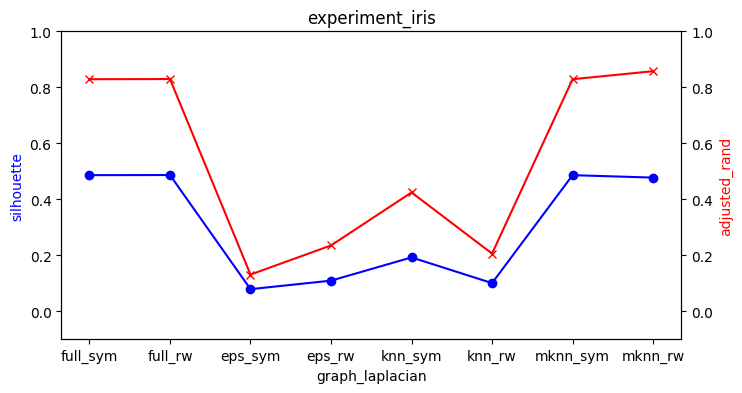

In [151]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot time on the first y-axis
ax.plot(experiment_iris['graph_laplacian'], experiment_iris['silhouette'], marker='o', color='b', label='Time (seconds)')

# Create a second y-axis
ax2 = ax.twinx()

# Plot memory on the second y-axis
ax2.plot(experiment_iris['graph_laplacian'], experiment_iris['adjusted_rand'], marker='x', color='r', label='Memory (KB)')

# Set labels and legends
ax.set_xlabel('graph_laplacian')
ax.set_ylabel('silhouette', color='b')
ax2.set_ylabel('adjusted_rand', color='r')

ax.set_ylim(-0.1, 1)
ax2.set_ylim(-0.1, 1)  # Adjust the multiplier as needed


# Add legends
# ax.legend(loc='upper left')
# ax2.legend(loc='upper right')

# Show the plot
plt.title('experiment_iris')
plt.show()

# Step-wise Breakdown

### Proximity

#### Distance Matrix

In [17]:
# Pairwise distances
dimension = data_df.shape[0]
dist_ = pdist(data_df)
dist_mat = np.zeros([dimension, dimension])
dist = iter(dist_)
for i in range(dimension):
    for j in range(i+1, dimension):  
        d = next(dist)
        dist_mat[i,j] = d
        dist_mat[j,i] = d

In [51]:
dist_mat

array([[0.        , 0.53851648, 0.50990195, ..., 1.91109916, 2.36012712,
        1.50525745],
       [0.53851648, 0.        , 0.3       , ..., 2.14576327, 2.51041829,
        1.72910381],
       [0.50990195, 0.3       , 0.        , ..., 2.31177421, 2.65710369,
        1.87930838],
       ...,
       [1.91109916, 2.14576327, 2.31177421, ..., 0.        , 1.01720204,
        0.49020404],
       [2.36012712, 2.51041829, 2.65710369, ..., 1.01720204, 0.        ,
        1.04038454],
       [1.50525745, 1.72910381, 1.87930838, ..., 0.49020404, 1.04038454,
        0.        ]])

#### Adjacency/ Similarity Matrix (Self-Tuning Spectral Clustering Algorithm)

In [19]:
#calculate local sigma
sigmas = np.zeros(dimension)
for i in range(len(dist_mat)):
    sigmas[i] = sorted(dist_mat[i])[7]

In [20]:
sigmas

array([0.17320508, 0.24494897, 0.3       , 0.3       , 0.26457513,
       0.4       , 0.42426407, 0.2236068 , 0.42426407, 0.26457513,
       0.34641016, 0.3       , 0.26457513, 0.58309519, 0.65574385,
       0.78740079, 0.45825757, 0.2       , 0.54772256, 0.33166248,
       0.42426407, 0.3       , 0.6       , 0.42426407, 0.5       ,
       0.3       , 0.3       , 0.24494897, 0.26457513, 0.26457513,
       0.24494897, 0.36055513, 0.45825757, 0.54772256, 0.26457513,
       0.34641016, 0.42426407, 0.26457513, 0.42426407, 0.24494897,
       0.26457513, 0.83666003, 0.31622777, 0.43588989, 0.50990195,
       0.26457513, 0.34641016, 0.3       , 0.31622777, 0.24494897,
       0.55677644, 0.42426407, 0.58309519, 0.50990195, 0.42426407,
       0.4       , 0.47958315, 0.84852814, 0.42426407, 0.54772256,
       0.88317609, 0.4       , 0.59160798, 0.43588989, 0.54772256,
       0.43588989, 0.4472136 , 0.38729833, 0.71414284, 0.36055513,
       0.52915026, 0.4472136 , 0.46904158, 0.50990195, 0.43588

In [21]:
# Adjaceny matrix with optimal sigma
adjacency_matrix = np.zeros([dimension, dimension])
dist = iter(dist_)
for i in range(dimension):
    for j in range(i+1, dimension):  
        d = np.exp(-1*next(dist)**2/(sigmas[i]*sigmas[j]))
        adjacency_matrix[i,j] = d
        adjacency_matrix[j,i] = d

In [119]:
adjacency_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

### Eigen Decomposition

In [120]:
# Calculate degree matrix
degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)

In [121]:
degree_matrix

array([[27.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 18.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 22., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 29.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  6.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 21.]])

In [122]:
# Normalized laplacian matrix
d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

In [123]:
laplacian_matrix_normalized

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.05025189, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05025189, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04052204],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.04052204, 0.        ,
        0.        ]])

In [29]:
# Calculating eigenvalues and eigenvectors

e, v = np.linalg.eigh(laplacian_matrix_normalized)

In [30]:
# Eigenvalues
e

array([-2.42514341e-01, -2.26311061e-01, -2.23027564e-01, -2.01539742e-01,
       -1.96689228e-01, -1.93091582e-01, -1.79766012e-01, -1.74297388e-01,
       -1.70254639e-01, -1.69393091e-01, -1.63446146e-01, -1.63160132e-01,
       -1.57833023e-01, -1.57454231e-01, -1.56492731e-01, -1.55658915e-01,
       -1.54691624e-01, -1.49925291e-01, -1.48399258e-01, -1.47607474e-01,
       -1.45847299e-01, -1.45750796e-01, -1.44641038e-01, -1.43453432e-01,
       -1.43299456e-01, -1.42085810e-01, -1.40245760e-01, -1.38637917e-01,
       -1.36336411e-01, -1.36299318e-01, -1.35716646e-01, -1.34790400e-01,
       -1.33585607e-01, -1.33239968e-01, -1.33137154e-01, -1.32881248e-01,
       -1.32316216e-01, -1.31737266e-01, -1.31039260e-01, -1.30689521e-01,
       -1.29943653e-01, -1.29418808e-01, -1.28784771e-01, -1.28670060e-01,
       -1.27997837e-01, -1.26905543e-01, -1.26725500e-01, -1.26485914e-01,
       -1.25833195e-01, -1.25812644e-01, -1.25310171e-01, -1.24844449e-01,
       -1.24844449e-01, -

In [31]:
# Eigenvectors
v

array([[ 1.04037536e-13, -2.49219929e-06,  7.31918697e-06, ...,
         9.02161324e-02, -8.38697567e-02,  6.76983589e-02],
       [-1.23936328e-13, -9.16775026e-06,  2.64873841e-05, ...,
         1.04700998e-01, -8.64970346e-02,  6.84579858e-02],
       [-1.70157888e-12,  1.89217487e-05, -5.02926896e-05, ...,
         1.12478318e-01, -9.31848218e-02,  7.37972806e-02],
       ...,
       [-8.60171724e-11,  4.61034577e-04, -1.18888138e-03, ...,
        -1.19130468e-01, -6.23152704e-02,  7.76795624e-02],
       [-1.63128124e-07, -1.46015514e-03, -1.62114232e-03, ...,
        -9.06433877e-02, -3.95169939e-02,  6.31213357e-02],
       [-5.14364651e-10, -4.11355993e-04,  9.79953416e-04, ...,
        -1.14646179e-01, -6.22279534e-02,  7.65320355e-02]])

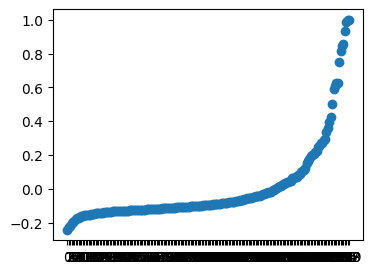

In [32]:
# Plotting the eigenvalues
plt.rcParams["figure.figsize"] = (4,3)
plt.scatter(range(len(e)), e);
plt.xticks(range(0,len(e)));

In [33]:
# Gaps in eigenvalues
gaps = np.diff(e)
eigen_gap_df = pd.DataFrame({'Index': range(len(e) - 1), 'Gap': gaps})
eigen_gap_df.sort_values(by='Gap', ascending=False, inplace=True)

In [28]:
eigen_gap_df

,Index,Gap
7,7,1.213289e-01
11,11,8.720370e-02
3,3,8.199862e-02
12,12,7.802965e-02
6,6,6.660777e-02
...,...,...
178,178,9.650206e-05
135,135,9.013678e-05
170,170,3.709311e-05
150,150,2.055114e-05


In [29]:
eigen_gap_df[eigen_gap_df['Index'] < 10]

,Index,Gap
7,7,0.121329
3,3,0.081999
6,6,0.066608
2,2,0.049620
5,5,0.029477
9,9,0.015934
1,1,0.011619
4,4,0.009755
0,0,0.002232
8,8,0.002184


In [34]:
# Eigen features for k
k = 4
X = v[:, -1*k:]
# row_sums = X.sum(axis=1)
# Y = X / row_sums[:, np.newaxis]

### Clustering

In [35]:
cluster_df = pd.DataFrame(X)
cluster_df

,0,1,2,3
0,-0.000617,0.090216,-0.083870,0.067698
1,-0.001989,0.104701,-0.086497,0.068458
2,-0.002125,0.112478,-0.093185,0.073797
3,-0.002247,0.113679,-0.093440,0.073902
4,-0.000622,0.096579,-0.090480,0.073136
...,...,...,...,...
195,0.004269,-0.113431,-0.056698,0.073251
196,0.004986,-0.108903,-0.056177,0.071597
197,0.007377,-0.119130,-0.062315,0.077680
198,-0.007841,-0.090643,-0.039517,0.063121


In [36]:
clustering = KMeans(n_clusters = 4)
clustering.fit(cluster_df)

cluster_labels = clustering.labels_
print(silhouette_score(data_df, cluster_labels),adjusted_rand_score(labels, cluster_labels))

0.48670812197703006 0.8293791343912085


C:\Users\mondal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
